# PS bunch generation: LIU 2021, 2022, 2023 Ramp-Up
# N.B. Python 3.0

In [25]:
# General imports
%matplotlib notebook
import sys
import numpy as np
from scipy.io import savemat
from scipy.constants import c
import matplotlib.pyplot as plt
from math import log10, floor

# BLonD imports
sys.path.append('./BLonD')
from blond.beam.beam import Proton, Beam
from blond.input_parameters.ring import Ring
from blond.input_parameters.rf_parameters import RFStation
from blond.trackers.tracker import RingAndRFTracker, FullRingAndRF
from blond.beam.distributions import matched_from_line_density

In [181]:
def round_sig(x, sig=3):
    return round(x, sig-int(floor(log10(abs(x))))-1)

def replace_point_with_p(input_str):
    return input_str.replace(".", "p")

In [ ]:
# Iterate over voltages save output file for each

voltages = dict()
v_step = 0.2 #kV
steps = 21
for i in range(steps):
    # Middle value must be 41.8kV
    min_voltage = 41.8 - ((steps - 1)/2 * v_step)
    if i is 0: print ('min_voltage = ', min_voltage)
    rf_voltage = round_sig(min_voltage + (i*v_step),3)    
    print ('rf_voltage = ', rf_voltage)
    
    voltages[replace_point_with_p(str(rf_voltage))] = rf_voltage*1E3

print(voltages)

for key, value in voltages.items():
    # Case selection
    n_macroparticles = 5e5
    beam_selection = 'Standard'
    year_selection = 2023

    # PS ring parameters
    circumference = 2*np.pi*100.
    bending_radius = 70.07887
    kinetic_energy = 2e9
    #gamma_t = 6.1
    gamma_t = 6.08378627 #2 GeV

    rf_harmonic = 7
    rf_voltage = value
    # PS bunch parameters Standard
    particle_type = Proton()
    full_bunch_length = 205e-9
    # full_emittance = 3.00
    bunch_intensity = 32.50e11
    line_density_type='parabolic_line'
            
    # Constructing BLonD objects

    # Ring object
    ring = Ring(circumference, 1/gamma_t**2., kinetic_energy, particle_type, synchronous_data_type='kinetic energy')

    # RF object
    rf_station = RFStation(ring, rf_harmonic, rf_voltage, np.pi)

    # Beam object
    beam = Beam(ring, n_macroparticles, bunch_intensity)

    # Tracker objects
    total_induced = None

    longitudinal_tracker = RingAndRFTracker(rf_station, beam, TotalInducedVoltage=total_induced)

    full_tracker = FullRingAndRF([longitudinal_tracker])

    # Bunch generation
    output_profile = matched_from_line_density( beam, full_tracker, TotalInducedVoltage=total_induced, bunch_length=full_bunch_length, line_density_type=line_density_type)[1]

    # Conversion
    particle_beta = np.sqrt(1-(beam.Particle.mass/(beam.energy+beam.dE))**2.)
    particle_z = -(beam.dt - rf_station.t_rf[0,0]/2.)*particle_beta*c


    # Using blond_common to verify separatrix and emittance
    from blond_common.rf_functions.potential import ( rf_potential_generation, find_potential_wells_cubic, potential_well_cut_cubic, trajectory_area_cubic)

    n_points = 1000
    t_rev = ring.t_rev[0]
    eta_0 = ring.eta_0[0,0]
    tot_energy = ring.energy[0,0]
    beta_rel = ring.beta[0,0]
    charge = ring.Particle.charge
    energy_increment = ring.delta_E[0]
    voltage = rf_station.voltage[0,0]
    harmonic = rf_station.harmonic[0,0]
    phi_rf = rf_station.phi_rf[0,0]

    # Separatrix trajectory
    time_bounds_sep = [output_profile[0][0], output_profile[0][-1]]

    time_array, rf_potential_array = rf_potential_generation( n_points, t_rev, voltage, harmonic, phi_rf, eta_0, charge, energy_increment, time_bounds=time_bounds_sep)

    potwell_max_locs = find_potential_wells_cubic( time_array, rf_potential_array)[0]

    time_array_list, potential_well_list = potential_well_cut_cubic( time_array, rf_potential_array, potwell_max_locs)

    (time_sep, dEsep, hamiltonian, calc_area_sep, half_energy_height, full_length_time) = trajectory_area_cubic( time_array_list[0], potential_well_list[0], eta_0, beta_rel, tot_energy)


    # Outter bunch trajectory
    time_bounds_bunch = [np.min(output_profile[0][output_profile[1]!=0.]), np.max(output_profile[0][output_profile[1]!=0.])]

    time_array, rf_potential_array = rf_potential_generation(n_points, t_rev, voltage, harmonic, phi_rf, eta_0, charge, energy_increment, time_bounds=time_bounds_bunch)

    potwell_max_locs = find_potential_wells_cubic(time_array, rf_potential_array)[0]

    (time_bunch, dEbunch, hamiltonian, calc_area_bunch, half_energy_height, full_length_time) = trajectory_area_cubic(time_array, rf_potential_array, eta_0, beta_rel, tot_energy)

    # First we need to make the data into a 2D array

    # Start with our data
    dE = np.array(beam.dE)
    dt = np.array((beam.dt - rf_station.t_rf[0,0]/2.))

    bin_size_x = 200
    bin_size_y = 200
    x_min = np.min(dt)*1.1
    x_max = np.max(dt)*1.1
    y_min = np.min(dE)*1.1
    y_max = np.max(dE)*1.1

    # Need a heatmap to make a 2D array:
    # Create heatmap
    #fig1 = plt.figure(facecolor='w', edgecolor='k')
    #ax1 = fig1.add_subplot(111)

    heatmap, xedges, yedges = np.histogram2d(dt, dE, bins=(bin_size_x, bin_size_y), range=[[x_min, x_max],[y_min, y_max]])
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    #ax1.imshow(heatmap, extent=extent, aspect=( (x_min - x_max)/(y_min - y_max) ) )
    
    # We want this in units of MeV and ns
    data = heatmap
    data_dict = {'time_nsec': xedges*1E9, 'energy_MeV': yedges*1E-6, 'density_array': data}
    fname = str('PyORBIT_Tomo_file_LIU_Ramp_Up_' + beam_selection +'_'+ key +'_'+str(year_selection) + '.mat')
    savemat(fname, data_dict)
    
    # Output figure

    plt.figure('Beam', figsize=(4,5))
    plt.clf()

    plt.subplot(211)
    plt.plot(beam.dt*1e9, beam.dE/1e6, '.',
             markersize=0.1, alpha=0.2)
    plt.plot(time_bunch*1e9, dEbunch/1e6, 'm')
    plt.plot(time_bunch*1e9, -dEbunch/1e6, 'm')
    plt.plot(time_sep*1e9, dEsep/1e6, 'r')
    plt.plot(time_sep*1e9, -dEsep/1e6, 'r')
    plt.xlim((0, rf_station.t_rf[0,0]*1e9))
    plt.gca().get_xaxis().set_visible(False)
    plt.ylabel('Energy [MeV]')
    plt.title('Emittance %.3f eVs'%(calc_area_bunch))

    plt.subplot(212)
    plt.plot(output_profile[0]*1e9, output_profile[1])
    plt.xlim((0, rf_station.t_rf[0,0]*1e9))
    plt.gca().get_yaxis().set_visible(False)
    plt.xlabel('Time [ns]')

    plt.tight_layout()
    plt.savefig('figure_'+str(beam_selection)+'_'+ key +'.png')



min_voltage =  39.8
rf_voltage =  39.8
rf_voltage =  40.0
rf_voltage =  40.2
rf_voltage =  40.4
rf_voltage =  40.6
rf_voltage =  40.8
rf_voltage =  41.0
rf_voltage =  41.2
rf_voltage =  41.4
rf_voltage =  41.6
rf_voltage =  41.8
rf_voltage =  42.0
rf_voltage =  42.2
rf_voltage =  42.4
rf_voltage =  42.6
rf_voltage =  42.8
rf_voltage =  43.0
rf_voltage =  43.2
rf_voltage =  43.4
rf_voltage =  43.6
rf_voltage =  43.8
{'39p8': 39800.0, '40p0': 40000.0, '40p2': 40200.0, '40p4': 40400.0, '40p6': 40600.0, '40p8': 40800.0, '41p0': 41000.0, '41p2': 41200.0, '41p4': 41400.0, '41p6': 41600.0, '41p8': 41800.0, '42p0': 42000.0, '42p2': 42200.0, '42p4': 42400.0, '42p6': 42600.0, '42p8': 42800.0, '43p0': 43000.0, '43p2': 43200.0, '43p4': 43400.0, '43p6': 43600.0, '43p8': 43800.0}


/home/HR/Documents/PS_LIU_Tunespread/12_RF_Check/Blone_Generator/blond_common/rf_functions/potential.py:451: RuntimeWarning: invalid value encountered in sqrt
  dEtraj = np.sqrt((potential_array[0]-potential_array) / eom_factor_dE)
/home/HR/Documents/PS_LIU_Tunespread/12_RF_Check/Blone_Generator/blond_common/rf_functions/potential.py:451: RuntimeWarning: invalid value encountered in sqrt
  dEtraj = np.sqrt((potential_array[0]-potential_array) / eom_factor_dE)
/home/HR/Documents/PS_LIU_Tunespread/12_RF_Check/Blone_Generator/blond_common/rf_functions/potential.py:451: RuntimeWarning: invalid value encountered in sqrt
  dEtraj = np.sqrt((potential_array[0]-potential_array) / eom_factor_dE)
/home/HR/Documents/PS_LIU_Tunespread/12_RF_Check/Blone_Generator/blond_common/rf_functions/potential.py:451: RuntimeWarning: invalid value encountered in sqrt
  dEtraj = np.sqrt((potential_array[0]-potential_array) / eom_factor_dE)


In [55]:
# Case selection
n_macroparticles = 5e5
beam_selection = 'Standard'
year_selection = 2023

# PS ring parameters
circumference = 2*np.pi*100.
bending_radius = 70.07887
kinetic_energy = 2e9
#gamma_t = 6.1
gamma_t = 6.08378627 #2 GeV

if beam_selection == 'Standard':
    # PS rf parameters Standard
    rf_harmonic = 7

    if year_selection == 2021:
        # PS bunch parameters Standard
        rf_voltage = 42.25e3
        #rf_voltage = 35e3
        particle_type = Proton()
        full_bunch_length = 135e-9
        # full_emittance = 1.50
        bunch_intensity = 32.50e11
        line_density_type='parabolic_line'

    elif year_selection == 2022:
        # PS bunch parameters Standard
        rf_voltage = 42.60e3
        particle_type = Proton()
        full_bunch_length = 170e-9
        # full_emittance = 2.25
        bunch_intensity = 32.50e11
        line_density_type='parabolic_line'

    elif year_selection == 2023:
        # PS bunch parameters Standard
        rf_voltage = 41.00e3
        rf_voltage = 41.10e3
        rf_voltage = 41.20e3
        rf_voltage = 41.30e3
        rf_voltage = 41.40e3
        rf_voltage = 41.50e3
        rf_voltage = 41.60e3
        rf_voltage = 41.70e3
        rf_voltage = 41.80e3
        rf_voltage = 41.90e3
        rf_voltage = 42.00e3
        rf_voltage = 42.10e3
        rf_voltage = 42.20e3
        rf_voltage = 42.30e3
        rf_voltage = 42.40e3
        rf_voltage = 42.50e3
        rf_voltage = 42.60e3
        rf_voltage = 42.70e3
        rf_voltage = 42.0e3
        particle_type = Proton()
        full_bunch_length = 205e-9
        # full_emittance = 3.00
        bunch_intensity = 32.50e11
        line_density_type='parabolic_line'

# elif beam_selection == 'BCMS':
#     # PS rf parameters BCMS
#     rf_harmonic = 9
#     rf_voltage = 36.55e3

#     # PS bunch parameters BCMS
#     particle_type = Proton()
#     full_bunch_length = 135e-9
#     # full_emittance = 1.48
#     bunch_intensity = 16.25e11
#     line_density_type='parabolic_line'

    Beta = 0.9476444679333867 #2 GeV
    E = 2.938237E9 # 2 GeV

    dpp_rms = round_sig(np.std(np.array(beam.dE))/E/Beta**2,5)
    print('dpp_RMS = ',round_sig(dpp_rms,5))

In [56]:
# Constructing BLonD objects

# Ring object
ring = Ring(circumference, 1/gamma_t**2.,
            kinetic_energy, particle_type,
            synchronous_data_type='kinetic energy')

# RF object
rf_station = RFStation(ring, rf_harmonic,
                       rf_voltage, np.pi)

# Beam object
beam = Beam(ring, n_macroparticles, bunch_intensity)

# Tracker objects
total_induced = None

longitudinal_tracker = RingAndRFTracker(rf_station, beam,
                                        TotalInducedVoltage=total_induced)

full_tracker = FullRingAndRF([longitudinal_tracker])

# Bunch generation
output_profile = matched_from_line_density(
    beam, full_tracker,
    TotalInducedVoltage=total_induced,
    bunch_length=full_bunch_length,
    line_density_type=line_density_type)[1]

# Conversion
particle_beta = np.sqrt(1-(beam.Particle.mass/(beam.energy+beam.dE))**2.)
particle_z = -(beam.dt - rf_station.t_rf[0,0]/2.)*particle_beta*c


In [57]:
# Using blond_common to verify separatrix and emittance

from blond_common.rf_functions.potential import (
    rf_potential_generation, find_potential_wells_cubic,
    potential_well_cut_cubic, trajectory_area_cubic)

n_points = 1000
t_rev = ring.t_rev[0]
eta_0 = ring.eta_0[0,0]
tot_energy = ring.energy[0,0]
beta_rel = ring.beta[0,0]
charge = ring.Particle.charge
energy_increment = ring.delta_E[0]
voltage = rf_station.voltage[0,0]
harmonic = rf_station.harmonic[0,0]
phi_rf = rf_station.phi_rf[0,0]


# Separatrix trajectory
time_bounds_sep = [output_profile[0][0],
                   output_profile[0][-1]]

time_array, rf_potential_array = rf_potential_generation(
    n_points, t_rev, voltage, harmonic, phi_rf, eta_0, charge, energy_increment,
    time_bounds=time_bounds_sep)

potwell_max_locs = find_potential_wells_cubic(
    time_array, rf_potential_array)[0]

time_array_list, potential_well_list = potential_well_cut_cubic(
    time_array, rf_potential_array, potwell_max_locs)

(time_sep, dEsep, hamiltonian, calc_area_sep,
 half_energy_height, full_length_time) = trajectory_area_cubic(
    time_array_list[0], potential_well_list[0],
    eta_0, beta_rel, tot_energy)


# Outter bunch trajectory
time_bounds_bunch = [np.min(output_profile[0][output_profile[1]!=0.]),
                     np.max(output_profile[0][output_profile[1]!=0.])]

time_array, rf_potential_array = rf_potential_generation(
    n_points, t_rev, voltage, harmonic, phi_rf, eta_0, charge, energy_increment,
    time_bounds=time_bounds_bunch)

potwell_max_locs = find_potential_wells_cubic(
    time_array, rf_potential_array)[0]

(time_bunch, dEbunch, hamiltonian, calc_area_bunch,
 half_energy_height, full_length_time) = trajectory_area_cubic(
    time_array, rf_potential_array,
    eta_0, beta_rel, tot_energy)



/home/HR/Documents/PS_LIU_Tunespread/12_RF_Check/Blone_Generator/blond_common/rf_functions/potential.py:451: RuntimeWarning: invalid value encountered in sqrt
  dEtraj = np.sqrt((potential_array[0]-potential_array) / eom_factor_dE)


## Calculate dpp_RMS

In [58]:
# Calculate delta_p/p RMS

# 2021
# gamma_t = 6.1          dpp_rms = 0.0012355
# gamma_t = 6.08378627   dpp_rms = 0.0012369

# 2023
# gamma_t = 6.1          dpp_rms = 0.0017115  # Should be 1.5E-3
# gamma_t = 6.08378627   dpp_rms = 0.0017111

#Beta = 0.915839281848 #1.4GeV
#E = 2336654575.29 # 1.4 GeV
Beta = 0.9476444679333867 #2 GeV
E = 2.938237E9 # 2 GeV

dpp_rms = np.std(np.array(beam.dE))/E/Beta**2
print('dpp_RMS = ',round_sig(dpp_rms,5))

dpp_RMS =  0.0017118


## Calculate Emittance

In [65]:
eps_z = np.std(np.array(beam.dE)) * np.std(np.array(beam.dt)) * np.pi
print ('eps_z = ', eps_z)

eps_z =  0.6485723214707804


## Find bucket height

In [138]:
def RF_bucket_height(Radius, V_RF, E_0, harmonic, slip_factor):
    return ((2*np.pi*Radius)/(np.pi*harmonic*299792458)) * np.sqrt( ( (- 1.602E-19 * V_RF * E_0)/(2 * np.pi * harmonic * slip_factor) ) )  
    
def RF_bucket_positive_limit(phase, Radius, V_RF, E_0, harmonic, slip_factor):
    return (RF_bucket_height(Radius, V_RF, E_0, harmonic, slip_factor) * np.sin(phase/2))

def Generate_RF_bucket(Radius, V_RF, E_0, harmonic, slip_factor):
    x_dat = np.linspace(0,(2*np.pi),100)
    y_dat = []
    for i in x_dat:
        y_dat.append(RF_bucket_positive_limit(i, Radius, V_RF, E_0, harmonic, slip_factor))
        
    return y_dat

def calc_slip_factor_from_gammas(gamma_tr, gamma_0):
    return( (1/(gamma_tr*gamma_tr)) - (1/(gamma_0*gamma_0)) )

slip_factor =  -0.07495473683903535
V_RF =  41800.0
W_bf =  1.9209104980675678e-10
Bucket area = 8 * W_bf  1.5367283984540543e-09


<IPython.core.display.Javascript object>


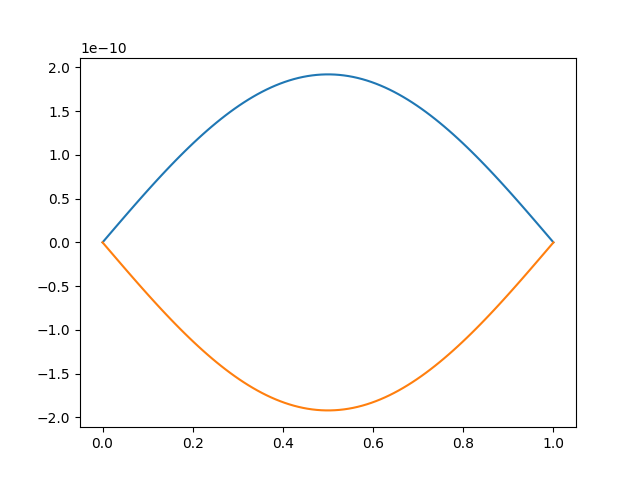

In [169]:
# From PTC for LIU 2021
gamma_0 = 3.131541
gamma_transition = 6.083786
eta_c = -0.074955
# Check slip factor
slip_factor = calc_slip_factor_from_gammas(gamma_transition, gamma_0)
print('slip_factor = ', slip_factor)

Radius = 628.318500/(2*np.pi)
V_RF = rf_voltage
print('V_RF = ', V_RF)
E_0 = kinetic_energy 
harmonic = 7
# Divide by bunch length?

W_bf = RF_bucket_height(Radius, V_RF, E_0, harmonic, slip_factor)
print('W_bf = ', W_bf)

print('Bucket area = 8 * W_bf ', 8*W_bf)

fig1 = plt.figure(facecolor='w', edgecolor='k')
ax1 = fig1.add_subplot(111)
x_dat = np.linspace(0,(2*np.pi),100)
y_dat = Generate_RF_bucket(Radius, V_RF, E_0, harmonic, slip_factor)
y_dat = np.array(y_dat)
y_dat_2 = -1*np.array(y_dat)
ax1.plot(x_dat/(2*np.pi), y_dat)
ax1.plot(x_dat/(2*np.pi), y_dat_2)


## Plot 

<IPython.core.display.Javascript object>


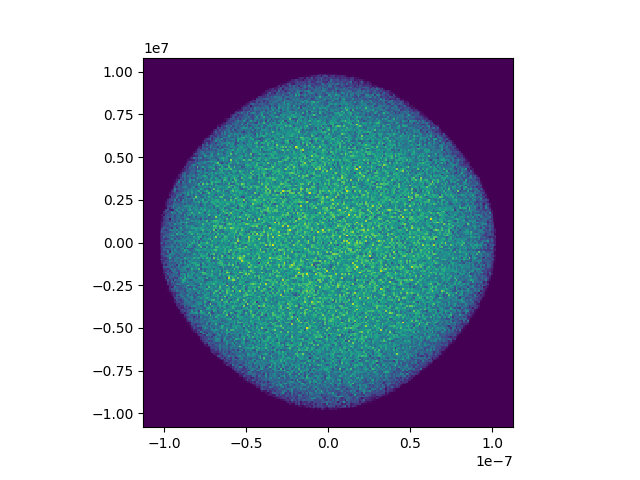

In [119]:
# First we need to make the data into a 2D array

# Start with our data
dE = np.array(beam.dE)
dt = np.array((beam.dt - rf_station.t_rf[0,0]/2.))

bin_size_x = 200
bin_size_y = 200
x_min = np.min(dt)*1.1
x_max = np.max(dt)*1.1
y_min = np.min(dE)*1.1
y_max = np.max(dE)*1.1

# Need a heatmap to make a 2D array:
# Create heatmap
fig1 = plt.figure(facecolor='w', edgecolor='k')
ax1 = fig1.add_subplot(111)

heatmap, xedges, yedges = np.histogram2d(dt, dE, bins=(bin_size_x, bin_size_y), range=[[x_min, x_max],[y_min, y_max]])
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
ax1.imshow(heatmap, extent=extent, aspect=( (x_min - x_max)/(y_min - y_max) ) )

<IPython.core.display.Javascript object>


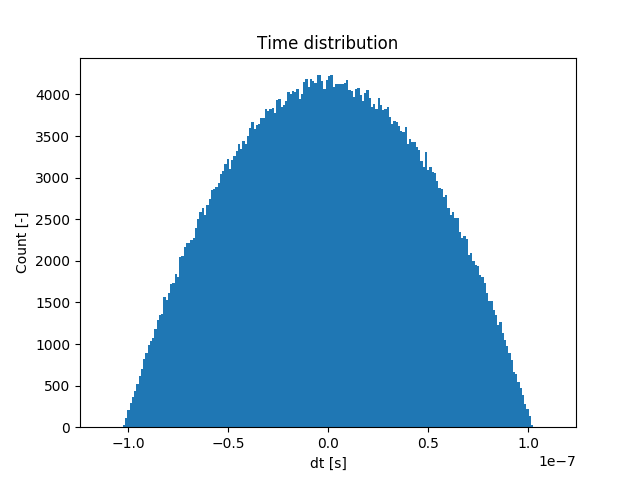

[Text(0, 0.5, 'Count [-]'),
 Text(0.5, 0, 'dt [s]'),
 Text(0.5, 1.0, 'Time distribution')]

In [120]:
# Check parabolic structure is maintained
# Create heatmap
fig1 = plt.figure(facecolor='w', edgecolor='k')
ax1 = fig1.add_subplot(111)

hist, bin_edges = np.histogram(dt, bins = bin_size_x, range=[x_min, x_max])
plt.hist(dt, bins = bin_size_x, range=[x_min, x_max])

ax1.set(xlabel='dt [s]', ylabel='Count [-]', title='Time distribution')

<IPython.core.display.Javascript object>


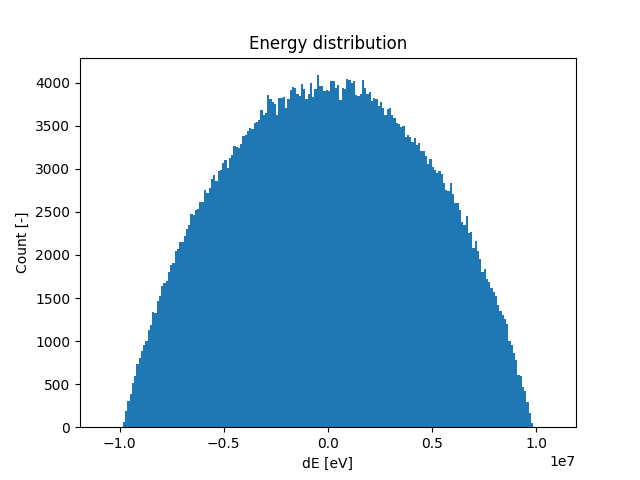

[Text(0, 0.5, 'Count [-]'),
 Text(0.5, 0, 'dE [eV]'),
 Text(0.5, 1.0, 'Energy distribution')]

In [60]:
# Check parabolic structure is maintained
# Create heatmap
fig1 = plt.figure(facecolor='w', edgecolor='k')
ax1 = fig1.add_subplot(111)

hist, bin_edges = np.histogram(dE, bins = bin_size_y, range=[y_min, y_max])
plt.hist(dE, bins = bin_size_y, range=[y_min, y_max])

ax1.set(xlabel='dE [eV]', ylabel='Count [-]', title='Energy distribution')

## Write tomo-style input file for PyORBIT

In [121]:
# We want this in units of MeV and ns
data = heatmap
data_dict = {'time_nsec': xedges*1E9, 'energy_MeV': yedges*1E-6, 'density_array': data}
fname = str('PyORBIT_Tomo_file_LIU_Ramp_Up_' + beam_selection +'_'+ str(year_selection) + '.mat')
savemat(fname, data_dict)

<IPython.core.display.Javascript object>


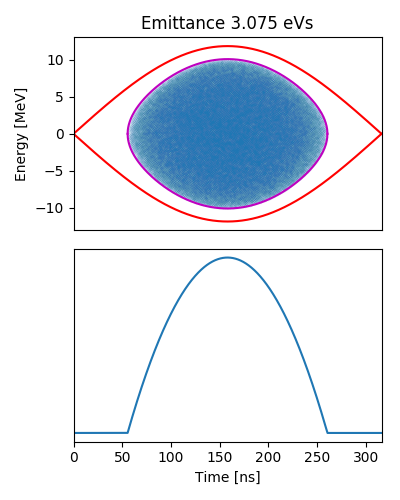

In [122]:
# Output figure

plt.figure('Beam', figsize=(4,5))
plt.clf()

plt.subplot(211)
plt.plot(beam.dt*1e9, beam.dE/1e6, '.',
         markersize=0.1, alpha=0.2)
plt.plot(time_bunch*1e9, dEbunch/1e6, 'm')
plt.plot(time_bunch*1e9, -dEbunch/1e6, 'm')
plt.plot(time_sep*1e9, dEsep/1e6, 'r')
plt.plot(time_sep*1e9, -dEsep/1e6, 'r')
plt.xlim((0, rf_station.t_rf[0,0]*1e9))
plt.gca().get_xaxis().set_visible(False)
plt.ylabel('Energy [MeV]')
plt.title('Emittance %.3f eVs'%(calc_area_bunch))

plt.subplot(212)
plt.plot(output_profile[0]*1e9, output_profile[1])
plt.xlim((0, rf_station.t_rf[0,0]*1e9))
plt.gca().get_yaxis().set_visible(False)
plt.xlabel('Time [ns]')

plt.tight_layout()
plt.savefig('figure_'+str(beam_selection)+'.png')

